In [1]:
import sys
sys.path.insert(1, '../scripts/')

from datetime import date, timedelta
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.linear_model import LinearRegression
from train_model import trainModel, getFeatures, standardScaler

In [2]:
STOCK_NAME = "BTC-USD"
# Using yahoo finance to get Stock data
df = yf.Ticker(STOCK_NAME).history(period="25mo").reset_index()

## Functions of the algorithm

In [3]:
def create_dtFeatures(dataframe):
    """
    Input:
        dataframe(pandas DataFrame):  BTC data
    Output:
        dataframe(pandas DataFrame): dataframe with the date time features
    """
    dataframe['Date'] = pd.to_datetime(df['Date'])
    dataframe['day'] = dataframe['Date'].dt.day
    dataframe['month'] = dataframe['Date'].dt.month
    dataframe['year'] = dataframe['Date'].dt.year
    return dataframe

In [4]:
create_dtFeatures(df).head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,day,month,year
0,2018-06-08,7685.14,7698.19,7558.40,7624.92,4227579904,0,0,8,6,2018
1,2018-06-09,7632.52,7683.58,7531.98,7531.98,3845220096,0,0,9,6,2018
2,2018-06-10,7499.55,7499.55,6709.07,6786.02,5804839936,0,0,10,6,2018
3,2018-06-11,6799.29,6910.18,6706.63,6906.92,4745269760,0,0,11,6,2018
4,2018-06-12,6905.82,6907.96,6542.08,6582.36,4654380032,0,0,12,6,2018


In [5]:
def create_laggedFeatures(dataframe, feature, shift_value):
    """
    Input:
        dataframe(pandas DataFrame): BTC data
        feature(string): the dataframe column
        shift_value(int): the value of the lagged feature
    Output:
        dataframe(pandas DataFrame): dataframe with the lagged feature
    """
    dataframe[feature + '_lagged'] = dataframe[feature].shift(shift_value)
    return dataframe

In [6]:
create_laggedFeatures(df, 'Close', 1).head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,day,month,year,Close_lagged
0,2018-06-08,7685.14,7698.19,7558.40,7624.92,4227579904,0,0,8,6,2018,NaN
1,2018-06-09,7632.52,7683.58,7531.98,7531.98,3845220096,0,0,9,6,2018,7624.92
2,2018-06-10,7499.55,7499.55,6709.07,6786.02,5804839936,0,0,10,6,2018,7531.98
3,2018-06-11,6799.29,6910.18,6706.63,6906.92,4745269760,0,0,11,6,2018,6786.02
4,2018-06-12,6905.82,6907.96,6542.08,6582.36,4654380032,0,0,12,6,2018,6906.92


In [7]:
def detrend(dataframe, feature):
    """
    Input:
        dataframe(pandas DataFrame): BTC data
        feature(string): feature that wil be detrended
    Output:
        detrend(np array): detrended values of features
        plots
    """
    X = [i for i in range(0, len(df))]
    X = np.reshape(X, (len(X), 1))
    y = dataframe[feature].values
    model = LinearRegression()
    model.fit(X, y)
    trend = model.predict(X)
    plt.plot(X, trend)
    plt.plot(X, dataframe[feature].values)
    plt.title('{} and linear trend'.format(feature))
    plt.show()
    detrend = y - trend
    plt.plot(X, detrend)
    plt.title('{} detrend'.format(feature))
    plt.show()
    return detrend

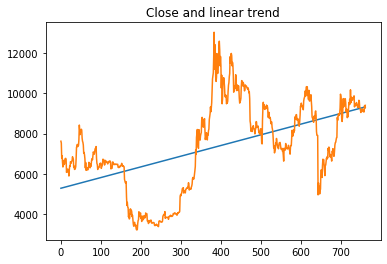

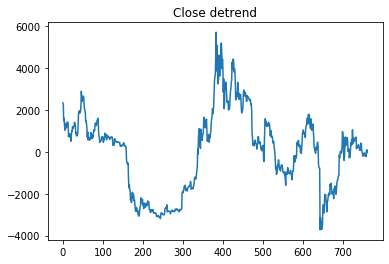

In [8]:
detrend = detrend(df, 'Close')

In [9]:
detrend[-10:] # showing the last 10 values of detrended Close values

array([ -82.77276083, -140.91829138,  -55.86382192, -166.06935247,
       -207.46488302, -167.56041356, -231.39594411,   64.84852534,
        -63.6270052 ,   79.59746425])

## Autocorrelation visualization

Autocorrelation of Close(t) and Close(t+1) observations, you can check more here: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/#:~:text=Autoregression%20is%20a%20time%20series,at%20the%20next%20time%20step.

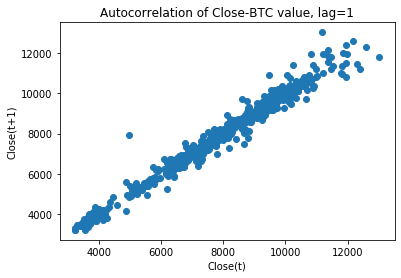

In [11]:
create_laggedFeatures(df, 'Close', 1)
plt.title('Autocorrelation of Close-BTC value, lag=1')
plt.scatter(df['Close'][1:], df['Close_lagged'][1:])
plt.xlabel('Close(t)')
plt.ylabel('Close(t+1)')
plt.show()

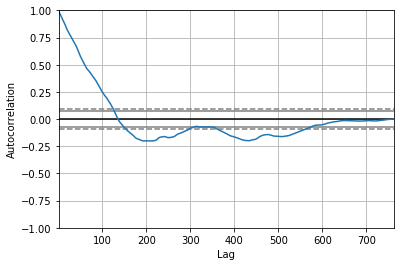

In [12]:
autocorrelation_plot(df['Close'])

## Moving average smoothing

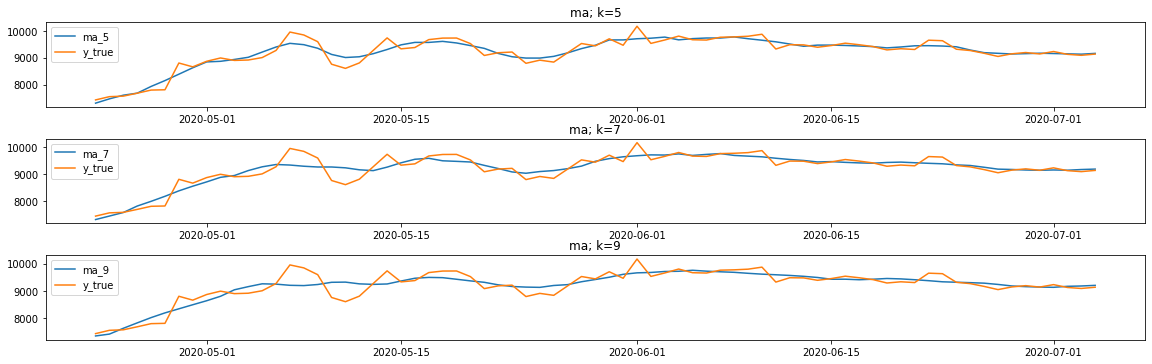

In [13]:
def ma_smoothing(dataframe, k):
    """
    Input:
        dataframe(pandas DataFrame): BTC data
        k(int): range of moving average
    Output:
        dataframe(pandas DataFrame): dataframe with the ma value
    """
    index = 0
    k_ = int((k-1)/2)
    ma_smoothing = []
    while index < len(dataframe)-k_:
        if index < k_:
            ma_smoothing.append(np.nan)
        else:    
            ma_smoothing.append(dataframe[index-k_:index+k_+1]['Close'].mean())
        index += 1
    for i in range(k_):
        ma_smoothing.append(np.nan)
    dataframe['ma_'+str(k)] = ma_smoothing
    return dataframe

ma_smoothing(df, 5)
ma_smoothing(df, 7)
ma_smoothing(df, 9)
df_ = df[int(len(df)*9/10):len(df)-4][['Date', 'Close', 'ma_5', 'ma_7', 'ma_9']]

dates = df_['Date']
y_true = df_['Close']
data = {'ma_5': df_['ma_5'],
       'ma_7': df_['ma_7'],
       'ma_9': df_['ma_9']}

fig, axs = plt.subplots(len(list(data.keys())), 1, figsize=[16, 5])
fig.tight_layout()
c = 0
for key in data.keys():
    axs[c].plot(dates, data[key], label=key)
    axs[c].plot(dates, y_true, label='y_true')
    axs[c].set_title('ma; k={}'.format(key.split('_')[1]))
    axs[c].legend()
    c += 1
plt.show()

## Modelling

In [14]:
def calculate_RMSE(y_pred, y_true):
    """
    Input:
        y_pred(np vector): predicted values
        y_true(np vector): true values
    Output:
        RMSE(float): value of Root Mean Square Error
    """
    n = len(y_pred)
    RMSE = (np.mean((y_pred - y_true)**2))**0.5
    return RMSE

In [15]:
# Setting the test size of the data
TEST_SIZE = int(len(df)*(9/10))

### Auto Regressive Model

In [16]:
avg_range = 7
index = len(df) - 1
X, y = [], []
while index-avg_range+1 > 0:
    X.append(df['Close'][index-avg_range:index].values)
    y.append(np.array([df.iloc[index]['Close']]))
    index = index - 1
    
X.reverse(), y.reverse()
X, y = np.array(X), np.array(y)

In [17]:
X_train, y_train = X[:TEST_SIZE], y[:TEST_SIZE]
X_test, y_test = X[TEST_SIZE:], y[TEST_SIZE:]

model_ar = LinearRegression()
model_ar.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

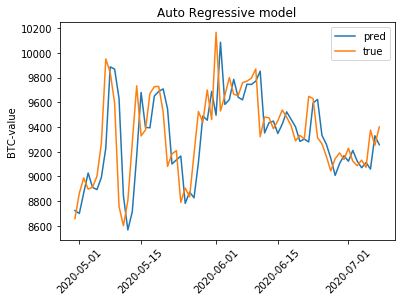

In [18]:
y_pred = model_ar.predict(X_test)
y_true = y_test
dates = df['Date'][TEST_SIZE:][7:]
plt.plot(dates, y_pred, label='pred')
plt.plot(dates, y_true, label='true')
plt.xticks(rotation=45)
plt.title('Auto Regressive model')
plt.ylabel('BTC-value')
plt.legend()
plt.show()

In [19]:
rmse_ar = calculate_RMSE(y_pred, y_true)
print('RMSE of Auto Regressive: {}'.format(round(rmse_ar, 2)))

RMSE of Auto Regressive: 265.39


### Moving Average Model

In [20]:
error = model_ar.predict(X) - y

In [21]:
X_train, y_train = error[:TEST_SIZE], y[:TEST_SIZE]
X_test, y_test = error[TEST_SIZE:], y[TEST_SIZE:]

model_ma = LinearRegression()
model_ma.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

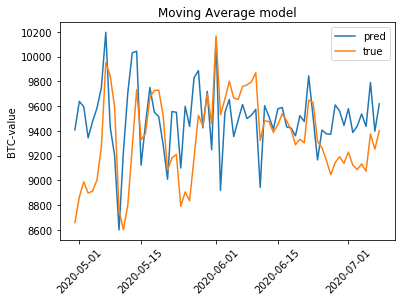

In [22]:
y_pred = model_ma.predict(X_test)
c = np.mean(y_train)/3 # c constant
y_pred = y_pred + c
y_true = y_test
dates = df['Date'][TEST_SIZE:][7:]
plt.plot(dates, y_pred, label='pred')
plt.plot(dates, y_true, label='true')
plt.xticks(rotation=45)
plt.title('Moving Average model')
plt.ylabel('BTC-value')
plt.legend()
plt.show()

In [23]:
rmse_ma = calculate_RMSE(y_pred, y_true)
print('RMSE of Auto Regressive: {}'.format(round(rmse_ma, 2)))

RMSE of Auto Regressive: 368.22


### LSTM Model

This is an example of the LSTM that I developed to predict stock values. This model uses the last 7 days values of the stock value do predict the current day. You can check the details of that network on train_model.py

In [24]:
df['Date'] = pd.to_datetime(df['Date']).apply(lambda x: x.date())
df_train = df[:TEST_SIZE]
df_test = df[TEST_SIZE:]

In [25]:
model_lstm = trainModel(df_train)

Epoch 1 completed!
Epoch 2 completed!
Epoch 3 completed!
Epoch 4 completed!
Epoch 5 completed!


In [26]:
index = 0
y_pred = []
dates = []
while index+8 < len(df_test):
    df_test_ = df_test[index:index+8]
    vec = getFeatures(df_test_, len(df_test_))[:-1]
    z = standardScaler(vec)
    x = np.array([z[0]])
    x = x.reshape(x.shape[0], 1, x.shape[1])
    yPred = model_lstm.predict(x)
    minValue, maxValue = z[1][0], z[1][1]
    yPred = yPred*(maxValue - minValue) + minValue
    y_pred.append(yPred[0][0])
    dates.append(df_test_['Date'][-1:].values)
    index += 1
    
y_true = df_test[7:len(df_test)-1]['Close'].values

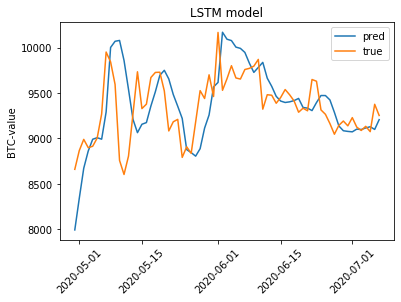

In [27]:
plt.plot(dates, y_pred, label='pred')
plt.plot(dates, y_true, label='true')
plt.xticks(rotation=45)
plt.title('LSTM model')
plt.ylabel('BTC-value')
plt.legend()
plt.show()

## References

Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on <07/07/2020>.